<a href="https://colab.research.google.com/github/MMoRann/UTS_ML2019_13065040/blob/master/A2_13065040_Ran_Mo_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [0]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CSV/default.csv')
data['industry'] = data['industry'].str.replace('Other Services \(except Public Administration\)','Other Services')
data['industry'] = data['industry'].str.replace('Accomodation','Accommodation')
data['industry'] = data['industry'].str.replace('Fishing or Hunting','Fishing and Hunting')
data['industry'] = data['industry'].fillna('Other Services')
data['industry'] = data['industry'].str.strip()
test = data.groupby('industry').size()

data = data.dropna(subset=['years_of_operation'], how='any')
data = data.dropna(subset=['fico_score'], how='any')
data = data[data['fico_score'] != 0]
data = data.dropna(subset=['business_employee_count'], how='any')
data = data.dropna(subset=['Homeowner'], how='any')

data['principal'] = data['principal'].str.replace('$','').str.replace(',','')
data['principal'] = data['principal'].astype(int)
data = data[data['status'] != 'current']
data['status'] = np.where(data['status'] == 'defaulted', 1, 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data.head(5)

,credit_rating,industry,state,years_of_operation,principal,interest_rate,term,status,fico_score,number_of_guarantors,business_employee_count,high_risk_industry,Broker,Homeowner
198,B,Other Services,CO,3.0,200000,0.1599,48,0,712.0,3,44.0,0,0,1.0
619,C,Real Estate and Rental and Leasing,TX,2.0,25000,0.1849,36,0,657.0,1,4.0,0,0,1.0
620,A,Other Services,SC,18.0,75000,0.1124,24,0,821.0,1,5.0,0,0,1.0
623,C,Transportation and Warehousing,AR,5.0,91000,0.1949,48,0,676.0,2,10.0,1,0,1.0
630,B,Wholesale Trade,FL,9.0,77312,0.1499,36,0,647.0,1,3.0,1,0,1.0


In [0]:
#Descriptive Statistics
data.describe()

,years_of_operation,principal,interest_rate,term,status,fico_score,number_of_guarantors,business_employee_count,high_risk_industry,Broker,Homeowner
count,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000,4709.000000
mean,10.649529,138240.356764,0.141907,40.885114,0.086855,706.117222,1.323636,14.522192,0.137184,0.305585,0.816946
std,7.991417,104803.995393,0.044720,14.908321,0.281652,44.579855,0.536434,53.189329,0.344078,0.460704,0.386752
min,0.000000,25000.000000,0.049900,6.000000,0.000000,604.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,60000.000000,0.111900,36.000000,0.000000,672.000000,1.000000,4.000000,0.000000,0.000000,1.000000
50%,8.600000,100000.000000,0.139900,36.000000,0.000000,703.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,13.800000,200000.000000,0.162900,60.000000,0.000000,738.000000,2.000000,14.000000,0.000000,1.000000,1.000000
max,67.000000,500000.000000,0.287900,60.000000,1.000000,843.000000,6.000000,2000.000000,1.000000,1.000000,1.000000


In [0]:
#dummy
data = pd.get_dummies(data,columns=['credit_rating'],prefix=['credit_rating'],prefix_sep="_",dummy_na=False,drop_first=False)
data = pd.get_dummies(data,columns=['industry'],prefix=['industry'],prefix_sep="_",dummy_na=False,drop_first=False)
data = data.reset_index(drop=True)

In [0]:
#split into train and test
random.seed(110)
train,test=train_test_split(data,test_size=0.3)
train_y = train['status']
train_x = train.drop(['status','state'],axis=1)
test_y = test['status']
test_x = test.drop(['status','state'],axis=1)

In [0]:
#Logistic regression
lm = LogisticRegression(solver='liblinear')
lm.fit(train_x,train_y)
predict_lm = lm.predict(test_x)
accuracy_lm = accuracy_score(test_y, predict_lm)
tn_lm, fp_lm, fn_lm, tp_lm = confusion_matrix(test_y, predict_lm).ravel()
sensitivity_lm = tp_lm / (tp_lm+fn_lm)
print("Accuracy is %s" %accuracy_lm)
print("Sensitivity is %s" %sensitivity_lm)
print(confusion_matrix(test_y, predict_lm))

Accuracy is 0.921443736730361
Sensitivity is 0.043859649122807015
[[1297    2]
 [ 109    5]]


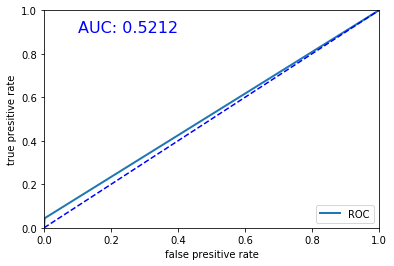

In [0]:
#Logistic regression ROC
fpr_lm,tpr_lm,thresholds = roc_curve(test_y, predict_lm,pos_label=1)
auc_lm = round(auc(fpr_lm, tpr_lm),4)
plt.plot(fpr_lm,tpr_lm,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], '--', color=(0 , 0, 1))
plt.legend(loc=4)
plt.text(0.1,0.9,'AUC: %s' %auc_lm,fontdict={'size':'16','color':'b'})
plt.show()

In [0]:
#random forest
rf = RandomForestClassifier(n_estimators=1000,random_state=110)
rf.fit(train_x,train_y)
predict_rf = rf.predict(test_x)
accuracy_rf = accuracy_score(test_y, predict_rf)
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(test_y, predict_rf).ravel()
sensitivity_rf = tp_rf / (tp_rf+fn_rf)
print("Accuracy is %s" %accuracy_rf)
print("Sensitivity is %s" %sensitivity_rf)
print(confusion_matrix(test_y, predict_rf))

Accuracy is 0.9249823071479123
Sensitivity is 0.21929824561403508
[[1282   17]
 [  89   25]]


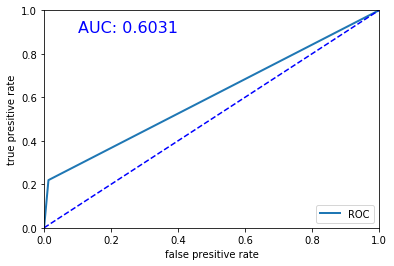

In [0]:
#random forest ROC
fpr_rf,tpr_rf,thresholds = roc_curve(test_y, predict_rf,pos_label=1)
auc_rf = round(auc(fpr_rf, tpr_rf),4)
plt.plot(fpr_rf,tpr_rf,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], '--', color=(0 , 0, 1))
plt.legend(loc=4)
plt.text(0.1,0.9,'AUC: %s' %auc_rf,fontdict={'size':'16','color':'b'})
plt.show()

In [0]:
#bagging
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=1000, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1)
bag.fit(train_x,train_y)
predict_bag = bag.predict(test_x)
accuracy_bag = accuracy_score(test_y, predict_bag)
tn_bag, fp_bag, fn_bag, tp_bag = confusion_matrix(test_y, predict_bag).ravel()
sensitivity_bag = tp_bag / (tp_bag+fn_bag)
print("Accuracy is %s" %accuracy_bag)
print("Sensitivity is %s" %sensitivity_bag)
print(confusion_matrix(test_y, predict_bag))

Accuracy is 0.9157820240622788
Sensitivity is 0.21929824561403508
[[1269   30]
 [  89   25]]


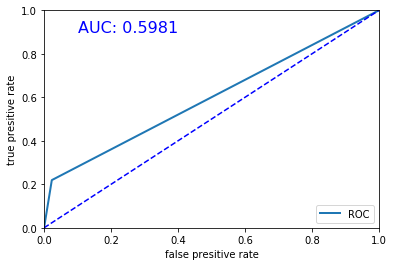

In [0]:
#bagging ROC
fpr_bag,tpr_bag,thresholds = roc_curve(test_y, predict_bag,pos_label=1)
auc_bag = round(auc(fpr_bag, tpr_bag),4)
plt.plot(fpr_bag,tpr_bag,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], '--', color=(0 , 0, 1))
plt.legend(loc=4)
plt.text(0.1,0.9,'AUC: %s' %auc_bag,fontdict={'size':'16','color':'b'})
plt.show()

In [0]:
#svm
sv = svm.SVC(gamma='auto')
sv.fit(train_x,train_y)
predict_svm = sv.predict(test_x)
accuracy_svm = accuracy_score(test_y, predict_svm)
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(test_y, predict_svm).ravel()
sensitivity_svm = tp_svm / (tp_svm+fn_svm)
print("Accuracy is %s" %accuracy_svm)
print("Sensitivity is %s" %sensitivity_svm)
print(confusion_matrix(test_y, predict_svm))

Accuracy is 0.9193205944798302
Sensitivity is 0.008771929824561403
[[1298    1]
 [ 113    1]]


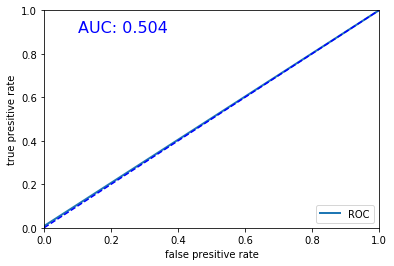

In [0]:
#svm ROC
fpr_svm,tpr_svm,thresholds = roc_curve(test_y, predict_svm,pos_label=1)
auc_svm = round(auc(fpr_svm, tpr_svm),4)
plt.plot(fpr_svm,tpr_svm,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], '--', color=(0 , 0, 1))
plt.legend(loc=4)
plt.text(0.1,0.9,'AUC: %s' %auc_svm,fontdict={'size':'16','color':'b'})
plt.show()